In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
df_customer = pd.read_csv("Customer.csv", delimiter=";")
df_product = pd.read_csv("Product.csv", delimiter=";")
df_store = pd.read_csv("Store.csv", delimiter=";")
df_transaction = pd.read_csv("Transaction.csv", delimiter=";")

In [3]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [4]:
df = pd.merge(pd.merge(pd.merge(df_customer, df_transaction, on='CustomerID'), df_product, on='ProductID'), df_store, on='StoreID')
df = df.drop(columns = "Price_y")
df.rename(columns={'Price_x': 'Price'}, inplace=True)
df

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,1,55,1,Married,"5,12",TR54475,23/02/2022,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
1,5,58,1,Married,"3,57",TR53643,22/05/2022,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
2,7,31,0,Married,"4,57",TR5151,10/03/2022,P8,16000,2,32000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
3,19,24,1,Single,"4,14",TR98635,18/06/2022,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
4,28,55,0,Married,"6,08",TR9420,12/01/2022,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,403,30,0,Married,"4,06",TR21751,07/10/2022,P9,10000,5,50000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5016,410,55,1,Married,"8,68",TR86692,05/04/2022,P9,10000,2,20000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5017,411,19,1,Single,0,TR67993,23/10/2022,P9,10000,2,20000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5018,427,54,0,Married,"16,88",TR28578,30/10/2022,P9,10000,3,30000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      5020 non-null   int64 
 1   Age             5020 non-null   int64 
 2   Gender          5020 non-null   int64 
 3   Marital Status  4976 non-null   object
 4   Income          5020 non-null   object
 5   TransactionID   5020 non-null   object
 6   Date            5020 non-null   object
 7   ProductID       5020 non-null   object
 8   Price           5020 non-null   int64 
 9   Qty             5020 non-null   int64 
 10  TotalAmount     5020 non-null   int64 
 11  StoreID         5020 non-null   int64 
 12  Product Name    5020 non-null   object
 13  StoreName       5020 non-null   object
 14  GroupStore      5020 non-null   object
 15  Type            5020 non-null   object
 16  Latitude        5020 non-null   object
 17  Longitude       5020 non-null   object
dtypes: int64

In [6]:
df['Income'] = df['Income'].replace('[,]', '.', regex=True).astype('float')
df['Latitude'] = df['Latitude'].replace('[,]', '.', regex=True).astype('float')
df['Longitude'] = df['Longitude'].replace('[,]', '.', regex=True).astype('float')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CustomerID      5020 non-null   int64         
 1   Age             5020 non-null   int64         
 2   Gender          5020 non-null   int64         
 3   Marital Status  4976 non-null   object        
 4   Income          5020 non-null   float64       
 5   TransactionID   5020 non-null   object        
 6   Date            5020 non-null   datetime64[ns]
 7   ProductID       5020 non-null   object        
 8   Price           5020 non-null   int64         
 9   Qty             5020 non-null   int64         
 10  TotalAmount     5020 non-null   int64         
 11  StoreID         5020 non-null   int64         
 12  Product Name    5020 non-null   object        
 13  StoreName       5020 non-null   object        
 14  GroupStore      5020 non-null   object        
 15  Type

### Mengecek dan Mengatasi Missing Value

In [8]:
df.isnull().sum()

CustomerID         0
Age                0
Gender             0
Marital Status    44
Income             0
TransactionID      0
Date               0
ProductID          0
Price              0
Qty                0
TotalAmount        0
StoreID            0
Product Name       0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
dtype: int64

In [9]:
# Membuat array nilai yang tersedia di kolom 'Marital Status' tanpa nilai yang hilang
available_values = df['Marital Status'].dropna().unique()

# Mengganti setiap nilai yang hilang dengan nilai acak dari array nilai yang tersedia
for index, row in df.iterrows():
    if pd.isnull(row['Marital Status']):
        df.at[index, 'Marital Status'] = np.random.choice(available_values)

In [10]:
#mengecek missing value setelah dilakukan pembersihan
df.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
TransactionID     0
Date              0
ProductID         0
Price             0
Qty               0
TotalAmount       0
StoreID           0
Product Name      0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
dtype: int64

### Mengecek dan Mengatasi Data Duplicate

In [11]:
#mengecek nilai unik dari setiap kolom
df.nunique()

CustomerID         447
Age                 54
Gender               2
Marital Status       2
Income             369
TransactionID     4908
Date               365
ProductID           10
Price               10
Qty                 10
TotalAmount         44
StoreID             14
Product Name        10
StoreName           12
GroupStore           7
Type                 2
Latitude            14
Longitude           14
dtype: int64

In [12]:
df['TransactionID'].value_counts()

TransactionID
TR71313    3
TR74019    2
TR38919    2
TR87715    2
TR54287    2
          ..
TR63136    1
TR11280    1
TR7587     1
TR5274     1
TR28578    1
Name: count, Length: 4908, dtype: int64

In [13]:
# Menghapus data duplikat berdasarkan kolom 'TransactionID', dengan mempertahankan baris terakhir
df.drop_duplicates(subset=['TransactionID'], keep='last', inplace=True)

In [14]:
df['TransactionID'].value_counts()

TransactionID
TR54475    1
TR74254    1
TR95040    1
TR8182     1
TR47837    1
          ..
TR15464    1
TR25829    1
TR29269    1
TR26836    1
TR88485    1
Name: count, Length: 4908, dtype: int64

# **Forecasting**

In [15]:
df_regression = df.groupby('Date')['Qty'].sum().reset_index()
df_regression

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,43
4,2022-01-05,30
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,41


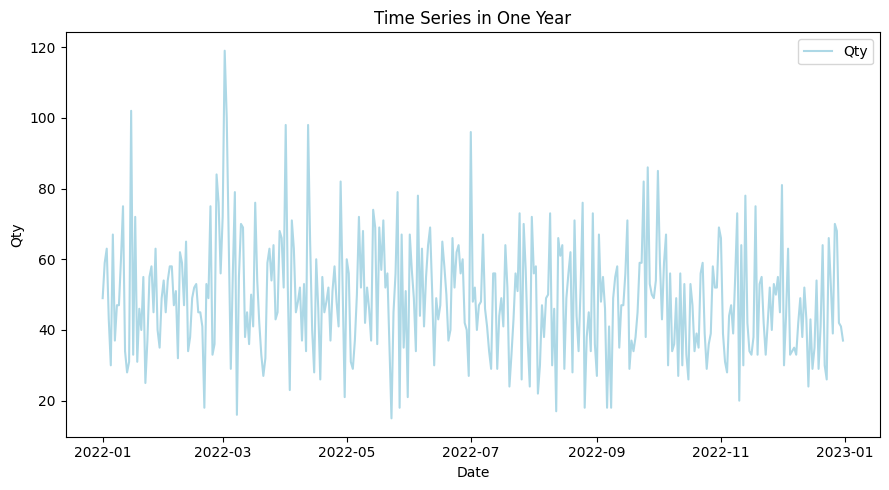

In [16]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df_regression['Date'], df_regression['Qty'], color='lightblue', label='Qty')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Time Series in One Year')
plt.legend()
plt.tight_layout()
plt.show()

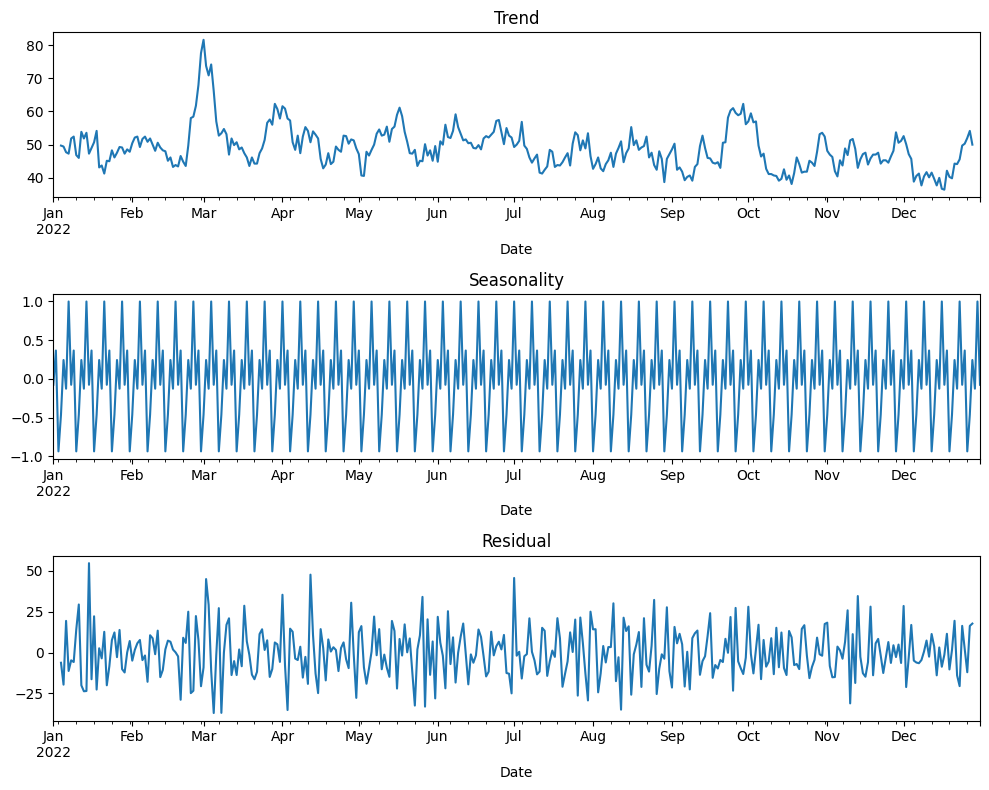

In [17]:
# Melakukan dekomposisi data
decomposed = seasonal_decompose(df_regression.set_index('Date'))

# Menampilkan plot tren menggunakan dekomposisi
plt.figure(figsize=(10, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')

plt.tight_layout()
plt.show()


In [16]:
from statsmodels.tsa.stattools import adfuller

# Melakukan uji stasioneritas menggunakan Augmented Dickey-Fuller (ADF) test
result = adfuller(df_regression['Qty'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] <= 0.05:
  print("\nThe data is stationary (reject the null hypothesis)")
else:
  print("\nThe data is non-stationary (fail to reject the null hypothesis)")


ADF Statistic: -19.131655296406304
p-value: 0.0
Critical Values:
	1%: -3.4484434475193777
	5%: -2.869513170510808
	10%: -2.571017574266393

The data is stationary (reject the null hypothesis)


<Figure size 1200x600 with 0 Axes>

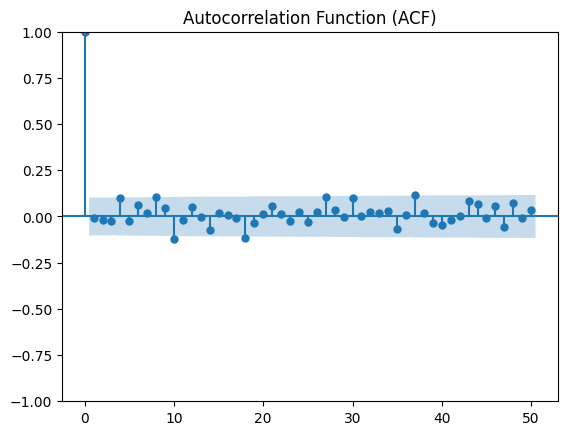

<Figure size 1200x600 with 0 Axes>

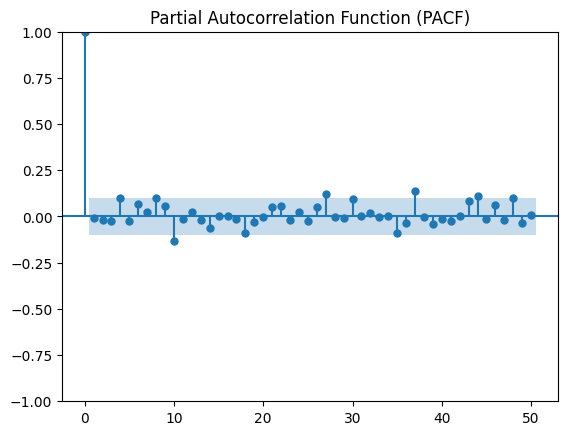

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df_regression['Qty'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df_regression['Qty'], lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [20]:
# from pmdarima import auto_arima

# # Gunakan metode Auto ARIMA untuk mendapatkan nilai p, d, dan q yang optimal
# stepwise_fit = auto_arima(df_regression['Qty'], start_p=1, start_q=1,
#                           max_p=50, max_q=50, m=12,
#                           start_P=0, seasonal=True,
#                           d=0, D=0, trace=True,
#                           error_action='ignore',  
#                           suppress_warnings=True, 
#                           stepwise=True)


In [18]:
cut_off = round(df_regression.shape[0] * 0.8) 
df_train = df_regression[:cut_off]
df_test = df_regression[cut_off:].reset_index(drop=True)

In [19]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,43
4,2022-01-05,30
...,...,...
287,2022-10-15,33
288,2022-10-16,26
289,2022-10-17,53
290,2022-10-18,47


In [20]:
df_test

,Date,Qty
0,2022-10-20,39
1,2022-10-21,35
2,2022-10-22,56
3,2022-10-23,59
4,2022-10-24,39
...,...,...
68,2022-12-27,70
69,2022-12-28,68
70,2022-12-29,42
71,2022-12-30,41


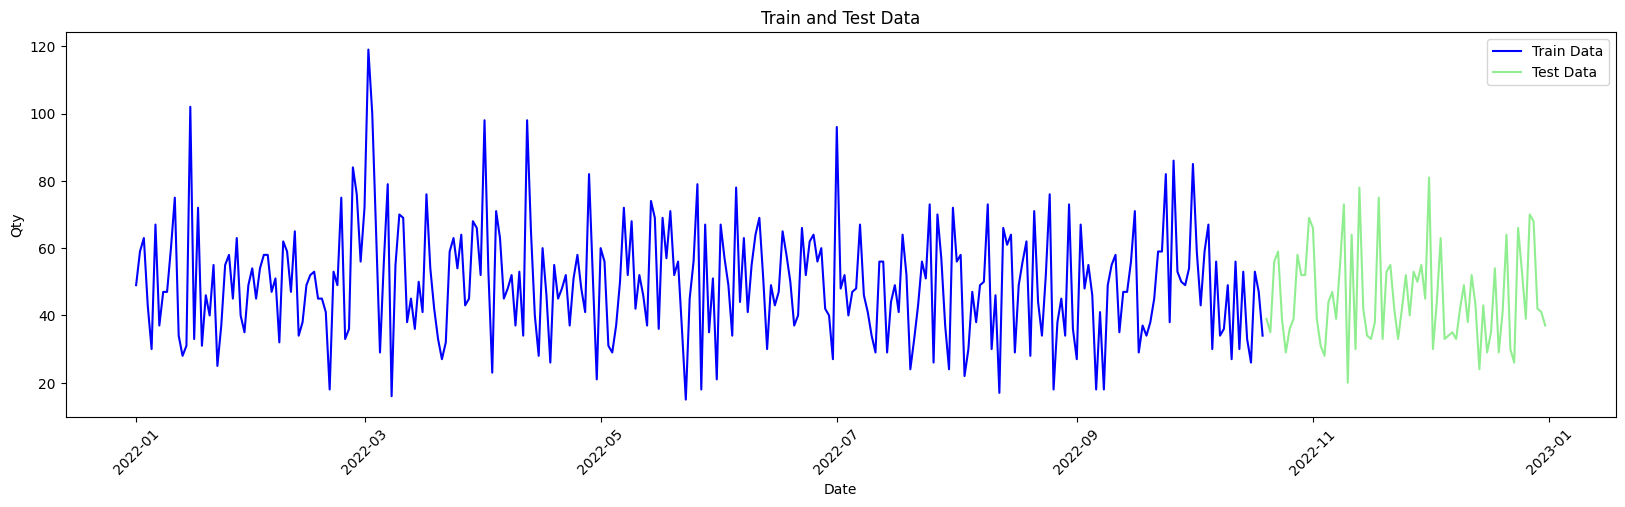

In [24]:

plt.figure(figsize=(20, 5))
plt.plot(df_train['Date'], df_train['Qty'], label='Train Data', color='blue')
plt.plot(df_test['Date'], df_test['Qty'], label='Test Data', color='lightgreen')
plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.xticks(rotation=45)  
plt.show()

In [23]:
import statsmodels.api as sm

p  = 0
q = 0
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2476.644241734637


In [24]:
import statsmodels.api as sm

p  = 0
q = 4
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2479.800640406495


In [25]:
import statsmodels.api as sm

p  = 0
q = 8
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2481.5657050329055


In [26]:
import statsmodels.api as sm

p  = 0
q = 10
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2481.77330128506


In [28]:
import statsmodels.api as sm

p  = 0
q = 18
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2482.8015579151206


In [29]:
import statsmodels.api as sm

p  = 0
q = 27
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2489.739330031138


In [30]:
import statsmodels.api as sm

p  = 0
q = 30
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2488.653634122163


In [31]:
import statsmodels.api as sm

p  = 0
q = 37
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2492.2277677943794


In [25]:
import statsmodels.api as sm

p  = 4
q = 4
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2482.796488639542


In [99]:
import statsmodels.api as sm

p  = 4
q = 8
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2475.7383546776314


In [30]:
import statsmodels.api as sm

p  = 4
q = 10
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2483.5852014910383


In [31]:
import statsmodels.api as sm

p  = 4
q = 18
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2488.5245406688036


In [32]:
import statsmodels.api as sm

p  = 4
q = 27
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2496.2005284973734


In [33]:
import statsmodels.api as sm

p  = 4
q = 30
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2496.0388790106363


In [34]:
import statsmodels.api as sm

p  = 4
q = 37
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2495.1569267388145


In [35]:
import statsmodels.api as sm

p  = 8
q = 4
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2483.1559416540686


In [36]:
import statsmodels.api as sm

p  = 8
q = 8
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2485.763724253005


In [37]:
import statsmodels.api as sm

p  = 8
q = 10
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2480.906318672556


In [38]:
import statsmodels.api as sm

p  = 8
q = 18
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2476.6573437789484


In [39]:
import statsmodels.api as sm

p  = 8
q = 27
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2487.166912535531


In [40]:
import statsmodels.api as sm

p  = 8
q = 30
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2495.948738493399


In [41]:
import statsmodels.api as sm

p  = 8
q = 37
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2504.8401094134683


In [42]:
import statsmodels.api as sm

p  = 10
q = 4
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2483.605604950394


In [43]:
import statsmodels.api as sm

p  = 10
q = 8
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2482.860010714745


In [44]:
import statsmodels.api as sm

p  = 10
q = 10
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2479.6004566436577


In [45]:
import statsmodels.api as sm

p  = 10
q = 18
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2479.5688590054365


In [46]:
import statsmodels.api as sm

p  = 10
q = 27
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2494.070501249679


In [47]:
import statsmodels.api as sm

p  = 10
q = 30
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2499.848775261362


In [48]:
import statsmodels.api as sm

p  = 10
q = 37
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2505.703220688861


In [49]:
import statsmodels.api as sm

p  = 18
q = 4
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2491.280226808118


In [50]:
import statsmodels.api as sm

p  = 18
q = 8
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2484.100430545894


In [51]:
import statsmodels.api as sm

p  = 18
q = 10
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2489.209448036468


In [52]:
import statsmodels.api as sm

p  = 18
q = 18
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2495.3238846815166


In [53]:
import statsmodels.api as sm

p  = 18
q = 27
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2498.2860406922555


In [54]:
import statsmodels.api as sm

p  = 18
q = 30
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2503.6410503725565


In [56]:
import statsmodels.api as sm

p  = 18
q = 37
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2512.928571755944


In [57]:
import statsmodels.api as sm

p  = 27
q = 4
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2492.8594126813387


In [58]:
import statsmodels.api as sm

p  = 27
q = 8
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2502.7005664423978


In [60]:
import statsmodels.api as sm

p  = 27
q = 17
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2509.8527203166855


In [62]:
import statsmodels.api as sm

p  = 27
q = 27
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2510.856812451494


In [61]:
import statsmodels.api as sm

p  = 27
q = 30
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2515.541104781036


In [63]:
import statsmodels.api as sm

p  = 27
q = 37
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2521.9802842533754


In [64]:
import statsmodels.api as sm

p  = 30
q = 4
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2498.955087718574


In [65]:
import statsmodels.api as sm

p  = 30
q = 8
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2499.9259030872754


In [66]:
import statsmodels.api as sm

p  = 30
q = 10
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2501.2222418323677


In [67]:
import statsmodels.api as sm

p  = 30
q = 18
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2512.59849310565


In [68]:

import statsmodels.api as sm

p  = 30
q = 27
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2515.4909777473285


In [69]:
import statsmodels.api as sm

p  = 30
q = 30
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2516.4806168079285


In [70]:
import statsmodels.api as sm

p  = 30
q = 37
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2529.083586649473


In [71]:
import statsmodels.api as sm

p  = 35
q = 4
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2504.483044133278


In [72]:
import statsmodels.api as sm

p  = 35
q = 8
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2503.99837671121


In [73]:
import statsmodels.api as sm

p  = 35
q = 10
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2507.5706408951996


In [74]:
import statsmodels.api as sm

p  = 35
q = 18
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2521.2756645715635


In [75]:
import statsmodels.api as sm

p  = 35
q = 27
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2521.5860777905227


In [76]:
import statsmodels.api as sm

p  = 35
q = 30
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2523.596930135999


In [77]:
import statsmodels.api as sm

p  = 35
q = 37
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2537.4662905659206


In [78]:
import statsmodels.api as sm

p  = 37
q = 4
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2508.426157637815


In [79]:
import statsmodels.api as sm

p  = 37
q = 8
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2506.7090955960743


In [80]:
import statsmodels.api as sm

p  = 37
q = 10
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2508.2305902168164


In [81]:
import statsmodels.api as sm

p  = 37
q = 18
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2515.406360150727


In [82]:
import statsmodels.api as sm

p  = 37
q = 27
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2521.5246436161788


In [83]:
import statsmodels.api as sm

p  = 37
q = 30
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2528.9550083663116


In [84]:
import statsmodels.api as sm

p  = 37
q = 37
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2539.0873980534916


In [85]:
import statsmodels.api as sm

p  = 44
q = 4
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2513.682336451012


In [86]:
import statsmodels.api as sm

p  = 44
q = 8
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2514.3151344353746


In [87]:
import statsmodels.api as sm

p  = 44
q = 10
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2520.9788946622884


In [88]:
import statsmodels.api as sm

p  = 44
q = 18
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2519.6682855445547


In [89]:
import statsmodels.api as sm

p  = 44
q = 27
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2531.7030969388297


In [90]:
import statsmodels.api as sm

p  = 44
q = 30
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2535.048961423903


In [91]:
import statsmodels.api as sm

p  = 44
q = 37
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2544.2975802012684


In [92]:
import statsmodels.api as sm

p  = 48
q = 4
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2516.3001839399712


In [93]:
import statsmodels.api as sm

p  = 48
q = 8
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2518.7894734706197


In [94]:
import statsmodels.api as sm

p  = 48
q = 10
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2521.838977690656


In [95]:
import statsmodels.api as sm

p  = 48
q = 18
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2528.7863566880474


In [96]:
import statsmodels.api as sm

p  = 48
q = 27
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2537.4476070804403


In [97]:
import statsmodels.api as sm

p  = 48
q = 30
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2537.70781053564


In [98]:
import statsmodels.api as sm

p  = 48
q = 37
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2546.8441010449637


In [100]:
import statsmodels.api as sm

p  = 10
q = 7
model = sm.tsa.ARIMA(df_train['Qty'], order=(p, 0, q))
model_fit = model.fit()

# Mendapatkan nilai AIC
aic = model_fit.aic

print(f"Nilai AIC: {aic}")

Nilai AIC: 2482.4344126344367


In [32]:
modelSARIMAX = sm.tsa.statespace.SARIMAX(df_train['Qty'], order=(0, 0, 0), seasonal_order=(0, 0, 0, 12))
model_fit_SARIMAX = modelSARIMAX.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38103D+00    |proj g|=  3.55271D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.553D-09   5.381D+00
  F =   5.3810286097348454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [33]:
aic_value = model_fit_SARIMAX.aic
print(aic_value)

3144.5207080851496


In [34]:
modelSARIMAX = sm.tsa.statespace.SARIMAX(df_train['Qty'], order=(4, 0, 4), seasonal_order=(4, 0, 4, 6))
model_fit_SARIMAX = modelSARIMAX.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26013D+00    |proj g|=  9.42979D-02


 This problem is unconstrained.



At iterate    5    f=  4.22670D+00    |proj g|=  7.12262D-02

At iterate   10    f=  4.22054D+00    |proj g|=  1.15954D-02

At iterate   15    f=  4.21105D+00    |proj g|=  4.62419D-02

At iterate   20    f=  4.20844D+00    |proj g|=  2.30107D-02

At iterate   25    f=  4.20768D+00    |proj g|=  1.17797D-02

At iterate   30    f=  4.20730D+00    |proj g|=  3.95211D-03

At iterate   35    f=  4.20704D+00    |proj g|=  1.72975D-02

At iterate   40    f=  4.20674D+00    |proj g|=  8.13708D-03

At iterate   45    f=  4.20524D+00    |proj g|=  4.12883D-02

At iterate   50    f=  4.20445D+00    |proj g|=  6.60934D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [35]:
aic_value = model_fit_SARIMAX.aic
print(aic_value)

2489.396579823915


In [36]:
modelSARIMAX = sm.tsa.statespace.SARIMAX(df_train['Qty'], order=(4, 0, 4), seasonal_order=(4, 0, 4, 7))
model_fit_SARIMAX = modelSARIMAX.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.42532D+00    |proj g|=  3.66023D-01

At iterate    5    f=  4.27062D+00    |proj g|=  6.33264D-02

At iterate   10    f=  4.23507D+00    |proj g|=  1.09007D-02

At iterate   15    f=  4.22885D+00    |proj g|=  9.73091D-03

At iterate   20    f=  4.22363D+00    |proj g|=  9.22507D-02

At iterate   25    f=  4.22125D+00    |proj g|=  2.00140D-02

At iterate   30    f=  4.21844D+00    |proj g|=  2.90960D-02

At iterate   35    f=  4.21784D+00    |proj g|=  2.80364D-02

At iterate   40    f=  4.21697D+00    |proj g|=  1.08798D-02

At iterate   45    f=  4.21674D+00    |proj g|=  8.32842D-03

At iterate   50    f=  4.21665D+00    |proj g|=  2.34030D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [37]:
aic_value = model_fit_SARIMAX.aic
print(aic_value)

2496.522275521314


In [38]:
modelSARIMAX = sm.tsa.statespace.SARIMAX(df_train['Qty'], order=(4, 0, 4), seasonal_order=(4, 0, 4, 8))
model_fit_SARIMAX = modelSARIMAX.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29098D+00    |proj g|=  1.30392D-01


 This problem is unconstrained.



At iterate    5    f=  4.25047D+00    |proj g|=  1.20278D-01

At iterate   10    f=  4.24299D+00    |proj g|=  1.02149D-02

At iterate   15    f=  4.23904D+00    |proj g|=  1.17005D-02

At iterate   20    f=  4.23330D+00    |proj g|=  1.03843D-01

At iterate   25    f=  4.23167D+00    |proj g|=  5.25377D-03

At iterate   30    f=  4.23110D+00    |proj g|=  1.08239D-02

At iterate   35    f=  4.23028D+00    |proj g|=  8.21889D-03

At iterate   40    f=  4.22971D+00    |proj g|=  1.30615D-02

At iterate   45    f=  4.22954D+00    |proj g|=  3.56562D-03

At iterate   50    f=  4.22937D+00    |proj g|=  6.07135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [39]:
aic_value = model_fit_SARIMAX.aic
print(aic_value)

2503.9525373728256


In [40]:
modelSARIMAX = sm.tsa.statespace.SARIMAX(df_train['Qty'], order=(4, 0, 4), seasonal_order=(4, 0, 4, 9))
model_fit_SARIMAX = modelSARIMAX.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40618D+00    |proj g|=  2.90123D-01

At iterate    5    f=  4.24544D+00    |proj g|=  5.30177D-02

At iterate   10    f=  4.23154D+00    |proj g|=  1.93400D-02

At iterate   15    f=  4.21923D+00    |proj g|=  2.00338D-02

At iterate   20    f=  4.21283D+00    |proj g|=  3.76499D-02

At iterate   25    f=  4.21157D+00    |proj g|=  6.46918D-03

At iterate   30    f=  4.21071D+00    |proj g|=  3.03514D-02

At iterate   35    f=  4.21036D+00    |proj g|=  2.47425D-02

At iterate   40    f=  4.20921D+00    |proj g|=  1.40753D-02

At iterate   45    f=  4.20807D+00    |proj g|=  9.11080D-02

At iterate   50    f=  4.20772D+00    |proj g|=  9.38116D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [41]:
aic_value = model_fit_SARIMAX.aic
print(aic_value)

2491.309344642601


In [57]:
modelSARIMAX = sm.tsa.statespace.SARIMAX(df_train['Qty'], order=(4, 0, 4), seasonal_order=(4, 0, 4, 20))
model_fit_SARIMAX = modelSARIMAX.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.49974D+00    |proj g|=  3.99819D-01

At iterate    5    f=  4.24626D+00    |proj g|=  4.77909D-02

At iterate   10    f=  4.23919D+00    |proj g|=  1.88024D-02

At iterate   15    f=  4.23612D+00    |proj g|=  9.36430D-03

At iterate   20    f=  4.23242D+00    |proj g|=  1.03708D-02

At iterate   25    f=  4.23018D+00    |proj g|=  1.09567D-02

At iterate   30    f=  4.22877D+00    |proj g|=  2.57502D-02

At iterate   35    f=  4.22797D+00    |proj g|=  3.10482D-02

At iterate   40    f=  4.22754D+00    |proj g|=  1.68706D-02

At iterate   45    f=  4.22713D+00    |proj g|=  9.70178D-03

At iterate   50    f=  4.22704D+00    |proj g|=  7.39274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [58]:
aic_value = model_fit_SARIMAX.aic
print(aic_value)

2502.589023750837


In [67]:
modelSARIMAX = sm.tsa.statespace.SARIMAX(df_train['Qty'], order=(4, 0, 8), seasonal_order=(4, 0, 8, 30))
model_fit_SARIMAX = modelSARIMAX.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.25508D+00    |proj g|=  1.48705D-01


 This problem is unconstrained.



At iterate    5    f=  4.23152D+00    |proj g|=  3.12893D-02

At iterate   10    f=  4.22330D+00    |proj g|=  1.31519D-02

At iterate   15    f=  4.22146D+00    |proj g|=  1.18368D-02

At iterate   20    f=  4.21796D+00    |proj g|=  1.45014D-02

At iterate   25    f=  4.21592D+00    |proj g|=  6.75444D-02

At iterate   30    f=  4.21487D+00    |proj g|=  6.70002D-02

At iterate   35    f=  4.21418D+00    |proj g|=  4.53479D-02

At iterate   40    f=  4.21382D+00    |proj g|=  3.92744D-02

At iterate   45    f=  4.21348D+00    |proj g|=  2.80905D-02

At iterate   50    f=  4.21323D+00    |proj g|=  7.82769D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [68]:
aic_value = model_fit_SARIMAX.aic
print(aic_value)

2510.5262119903546


In [69]:
# Membuat prediksi dengan model yang telah dibangun
forecast_SARIMAX = model_fit_SARIMAX.forecast(steps=len(df_test))  

# Menampilkan hasil prediksi
print(forecast_SARIMAX)

292    53.280206
293    45.173385
294    54.510786
295    43.165745
296    54.637873
         ...    
360    45.976963
361    47.121261
362    46.213776
363    45.555072
364    49.779503
Name: predicted_mean, Length: 73, dtype: float64


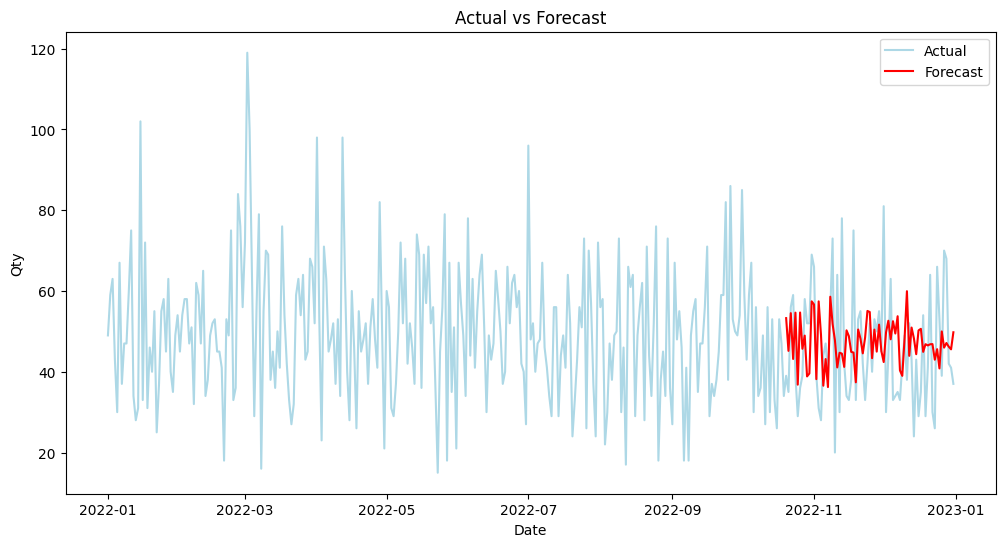

In [70]:
import matplotlib.pyplot as plt

# Ubah df_test dan forecast dengan data yang sesuai
plt.figure(figsize=(12,6))
plt.plot(df_regression['Date'], df_regression['Qty'], label='Actual', color = 'lightblue')
plt.plot(df_test['Date'], forecast_SARIMAX, label='Forecast', color='red')
plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.show()

In [1]:
import statsmodels.api as sm

# Membangun model SARMA
model_SARMA = sm.tsa.SARIMAX(df_regression['Qty'], order=(4, 0, 8), seasonal_order=(4, 0, 8, 12))
model_fit_SARMA = model_SARMA.fit()

# Melihat hasil AIC dari model yang dipilih
print(model_fit_SARMA.aic)

# Menampilkan ringkasan model
print(model_fit_SARMA.summary())


NameError: name 'df_regression' is not defined